In [41]:
import sys
import csv
sys.path.append('..')
from BDDData import *
import numpy as np
import torch
import torch.utils.data as data
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import circulant
from product_graph import *
from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
#Load dataframes
bdd_data = BDD_dataset("raw_data/BDDdata/")
#Add column with the timestep
bdd_data.add_timestep_id()
#Add flags for chaotic values
bdd_data.tag_chaotic(replace=True)
#Compute the mod for the nazelle and wind angles
bdd_data.angle_mod()

# ! Don't interpolate this data
# ! Missing values remain NaN
# #Interpolate the missing values
# bdd_data.interpolate_power()

#Values smaller than 0 are set to 0
bdd_data.cap_power_to_zero()
#Normalize Patv feature to [0,1]
bdd_data.normalize_power(min=0, max=1, method= "MinMaxScaler")
#Convert df to matrix form, where only Patv is included. Then split into train, validation and test
#The matrix contains the subset of the time series for ALL nodes, so an (TxN matrix)
train, val, test = bdd_data.split_df()

print(train.shape)

(134, 24624)


In [44]:
# set seed
np.random.seed(42)
# consider a p percentage of the data
p = 0.01
train_mask = np.random.choice(train.shape[1], int(train.shape[1] * p), replace=False)
val_mask = np.random.choice(val.shape[1], int(val.shape[1] * p), replace=False)
test_mask = np.random.choice(test.shape[1], int(test.shape[1] * p), replace=False)

train = train[:, train_mask]
val = val[:, val_mask]
test = test[:, test_mask]

In [45]:
class CustomBDD_Dataset(data.Dataset):
    def __init__(self, dataset, observation_window=12, forecast_window=12, starting_turbine = 0,  ending_turbine=133):
        self.observation_window = observation_window
        self.forecast_window = forecast_window
        length = eval(f'len({dataset}[0])')#Retrieves length of dataset
        bdd_data.get_observation_forecasting_window(time_series_len=length, observation_steps=self.observation_window, forecast_steps=self.forecast_window)#Generates obs window
        self.window_of_interest =  bdd_data.sliding_indices[str(self.observation_window)+","+str(self.forecast_window)]#Retrieves windows
        self.starting_turbine = starting_turbine
        self.ending_turbine = ending_turbine  
        self.dataset = dataset

    def __len__(self):
        return len(self.window_of_interest)

    def __getitem__(self, idx):
        window = self.window_of_interest[idx]
        if self.dataset == "train":
            features = train[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = train[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        elif self.dataset == "val":
            features = val[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = val[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        elif self.dataset == "test":
            features = test[self.starting_turbine:self.ending_turbine+1,window[0]:window[1]].transpose().reshape(-1, 1)
            labels = test[self.starting_turbine:self.ending_turbine+1,window[1]:window[2]].transpose().reshape(-1, 1)
        else:
            raise NotImplementedError
        return torch.from_numpy(features).float(), torch.from_numpy(labels).float()
    
obs_window = 12
forecast_window = 12
batch_size = 100

train_dataset = CustomBDD_Dataset("train",observation_window=obs_window,forecast_window=forecast_window)
train_loader = data.DataLoader(train_dataset, shuffle=True, batch_size = batch_size)
val_dataset = CustomBDD_Dataset("val",observation_window=obs_window,forecast_window=forecast_window)
val_loader = data.DataLoader(val_dataset, shuffle=True, batch_size = batch_size)

In [46]:
x,y = next(iter(train_loader))
print(f"{x.shape=}\n{y.shape=}")

x.shape=torch.Size([100, 1608, 1])
y.shape=torch.Size([100, 1608, 1])


In [47]:
G = nx.read_gml('data/spatial_graph_2000.gml')
adj_mat = nx.adjacency_matrix(G)
adj_mat = nx.to_numpy_array(G)

In [48]:
def build_time_graph(window: int, directed: bool, cyclic: bool):
    """
    Circulant matrix as in https://arxiv.org/pdf/1712.00468.pdf (eq. 7)
    """
    if window <= 1:
        raise Exception("Ehm..")
    adjacency = circulant([0, 1] + [0 for _ in range(window-2)])
    if not cyclic:
        adjacency[0, window-1] = 0
    if not directed:
        adjacency += adjacency.transpose()

    return adjacency

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]]


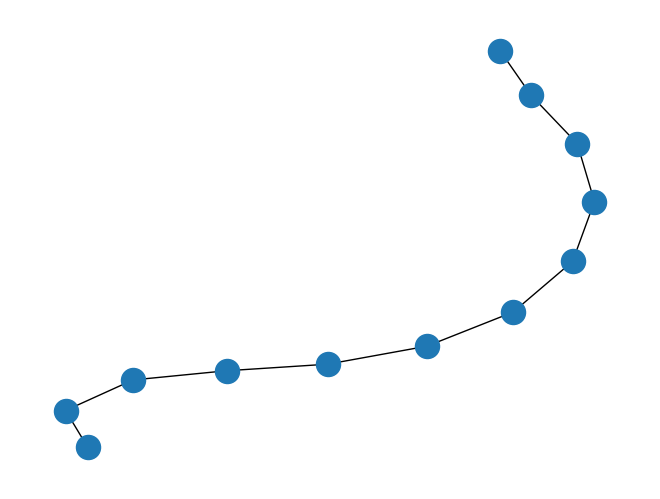

In [49]:
timegraph = build_time_graph(12,True,False)
print(timegraph)
tg = nx.from_numpy_array(timegraph)
nx.draw(tg)

In [50]:
# Normalize the adjacency matrix
S = normalize_adjacency(torch.tensor(adj_mat)).float()
S_t = torch.tensor(timegraph)

In [51]:
# Cartesian
pg = build_parametric_product_graph(S_t, S, 0, 1, 1, 1).float().to(device)

In [52]:
print(pg.shape)

torch.Size([1608, 1608])


In [53]:
# FOR GMM Implementation
# ! Taken from the paper.
def ex_relu(mu, sigma):
    is_zero = sigma == 0
    sigma = torch.where(is_zero, torch.tensor(1e-10, device=sigma.device), sigma)
    sqrt_sigma = torch.sqrt(sigma)
    w = torch.div(mu, sqrt_sigma)
    nr_values = sqrt_sigma * (
            torch.div(torch.exp(torch.div(-w * w, 2)), np.sqrt(2 * np.pi))
            + torch.div(w, 2) * (1 + torch.erf(torch.div(w, np.sqrt(2))))
    )
    nr_values = torch.where(is_zero, F.relu(mu), nr_values)
    return nr_values

In [54]:
class GMMGCNNLayer(nn.Module):
    """This extends the GMMGCNLayer, adding order q. Forward pass LMW becomes Sum over q of L^qMW."""

    def _init_gmm(self, features, K):
        # Simply impute the values once for initialization of the gmm.
        # Keep empty features
        imputer = SimpleImputer(
            missing_values=np.nan, strategy="mean", keep_empty_features=True
        )
        imputed_x = imputer.fit_transform(features)
        gmm = GaussianMixture(n_components=K, covariance_type="diag").fit(imputed_x)
        return gmm

    # ! Taken from the paper.
    def _calc_responsibility(self, mean_mat, variances):
        dim = self.in_features
        log_n = (
                (-1 / 2)
                * torch.sum(
            torch.pow(mean_mat - self.mu.unsqueeze(1), 2) / variances.unsqueeze(1),
            2,
        )
                - (dim / 2) * np.log(2 * np.pi)
                - (1 / 2) * torch.sum(self.sigma)
        )
        log_prob = self.pi.unsqueeze(1) + log_n
        return torch.softmax(log_prob, dim=0)

    def __init__(
        self,
        in_features,
        out_features,
        num_components,
        all_features,
        all_A,
        order,
        device="cpu",
    ) -> None:
        super(GMMGCNNLayer, self).__init__()

        self.device = device

        self.num_components = num_components
        self.in_features = in_features
        self.out_features = out_features

        # All feature data, used for initialization of the GMM.
        self.all_features = all_features

        self.all_A = all_A
        self.order = order

        # Initialize the weights
        self.weights = nn.Parameter(torch.FloatTensor(order+1, in_features, out_features))
        nn.init.xavier_uniform_(self.weights)

        # Initialize GMM and its parameters (we're going to learn these)
        self.gmm = self._init_gmm(self.all_features, self.num_components)
        self.pi = nn.Parameter(torch.FloatTensor(np.log(self.gmm.weights_))).to(
            self.device
        )
        self.mu = nn.Parameter(torch.FloatTensor(self.gmm.means_).to(self.device))
        self.sigma = nn.Parameter(
            torch.FloatTensor(np.log(self.gmm.covariances_)).to(self.device)
        )

        # Prepare shifts for all orders in one go
        self.shifts = [torch.matrix_power(all_A, q) for q in range(self.order+1)]
        # self.A2s = [torch.mul(self.shifts[q], self.shifts[q]).to(self.device) for q in range(self.order+1)]
        self.A2s = []
        for q1 in range(order+1):
            for q2 in range(order+1):
                 self.A2s.append(torch.spmm(self.shifts[q1], self.shifts[q2]))

    def forward(self, features):
        batch_size = features.size(0)
        tensor_list = []
        for i in range(batch_size):
            out = self._forward(features[i])
            tensor_list.append(out)
        return torch.stack(tensor_list, dim=0)

    def _forward(self, features):
        x_imp = features.repeat(self.num_components, 1, 1)
        x_isnan = torch.isnan(x_imp)
        variances = torch.exp(self.sigma)
        # M
        mean_mat = torch.where(
            x_isnan, self.mu.repeat((features.size(0), 1, 1)).permute(1, 0, 2), x_imp
        )
        # S
        var_mat = torch.where(
            x_isnan,
            variances.repeat((features.size(0), 1, 1)).permute(1, 0, 2),
            torch.zeros(size=x_imp.size(), device=self.device, requires_grad=True),
        )

        # M^kW
        transform_x = []
        for q in range(self.order+1):
            transform_x.append(torch.matmul(mean_mat, self.weights[q]))
        # Becomes: # M^k W_q
        # S^k (W * W)
        # transform_covs = torch.matmul(var_mat, self.weight * self.weight)
        # Becomes:
        transform_covs = []
        for q1 in range(self.order+1):
            for q2 in range(self.order+1):
                transform_covs.append(torch.matmul(var_mat, self.weights[q1] * self.weights[q2]))
        
        conv_x = []
        conv_covs = []

        # for component_x in transform_x:
        for component_index in range(self.num_components):
            # First:
            # LM^kW
            # conv_x.append(torch.spmm(shift, component_x))

            # Becomes:
            # sum over Q of (L^q M^k W)

            # Second iteration, becomes:
            # Add weights for every layer.
            # sum over Q of (L^q M^k W_q)
            out = torch.stack([torch.spmm(self.shifts[q], transform_x[q][component_index]) for q in range(self.order+1)]).mean(dim=0)

            conv_x.append(out)

        # Transform_covs used to be shape: torch.Size([5, 1608, 1])
        # for component_covs in transform_covs:
        for component_index in range(self.num_components):
            # First:
            # (L*L) S^k
            # conv_covs.append(torch.spmm(self.A2, component_covs))

            # Becomes:
            # sum over Q of ( (L^q * L^q) S^k W * W)
            # out = torch.stack([torch.spmm(self.A2s[q], component_covs) for q in range(self.order)]).mean(dim=0)

            # Second iteration, becomes:
            # sum over Q of ( (L^q1 * L^q2) S^k W_q1 * W_q1)
            out = []
            for q1 in range(self.order+1):
                for q2 in range(self.order+1):
                    # Index where we retrieve the precomputed tensors from
                    index = q1*(self.order+1)+q2
                    component_cov = transform_covs[index][component_index]
                    weights = self.weights[q1] * self.weights[q2]
                    # out.append(torch.spmm(torch.spmm(torch.spmm(torch.matrix_power(self.all_A, q1), torch.matrix_power(self.all_A, q2)), component_cov), weights.T))
                    out.append(torch.spmm(torch.spmm(self.A2s[index], component_cov), weights.T))
                
            conv_covs.append(torch.stack(out).mean(dim=0))

        transform_x = torch.stack(conv_x, dim=0)
        transform_covs = torch.stack(conv_covs, dim=0)
        # ReLU[N(M, S)]
        expected_x = ex_relu(transform_x, transform_covs)

        # calculate responsibility
        gamma = self._calc_responsibility(mean_mat, variances)
        # ReLU[(LXW)]
        expected_x = torch.sum(expected_x * gamma.unsqueeze(2), dim=0)
        # Check for NaNs
        if torch.isnan(expected_x).any():
            print("NaN detected in expected_x:")
        return expected_x

In [55]:
class GCNNLayer(nn.Module):
    def __init__(self, in_features, out_features, matrix_powers, order):
        super(GCNNLayer, self).__init__()
        self.matrix_powers = matrix_powers
        self.order = order
        self.weights = nn.Parameter(torch.FloatTensor(in_features, out_features, order+1))
        # use Xavier initialization to match variance of input with output
        nn.init.xavier_uniform_(self.weights)

    def forward(self, features):
        batch_size = features.size(0)
        output_dim = self.weights.size(1)
        device = features.device

        out = torch.zeros((batch_size, features.size(1), output_dim), device=device)
        for k in range(self.order+1):
            weighted = torch.bmm(features, self.weights[:, :, k].unsqueeze(0).repeat(batch_size, 1, 1))
            shifted = torch.bmm(self.matrix_powers[k].unsqueeze(0).repeat(batch_size, 1, 1).to(device), weighted)
            out += shifted
        return out

In [56]:
class GMMGCNN(nn.Module):

    def __init__(
        self, obs_size, pred_size, hid_sizes, num_components, all_features, all_A, order
    ):
        super(GMMGCNN, self).__init__()
        self.layers = nn.ModuleList()

        # First layer is a GCNN that incorporates the GMM.
        self.layers.append(
            GMMGCNNLayer(
                obs_size, hid_sizes[0], num_components, all_features, all_A, order, device=device
            )
        )

        # Later layers are regular GCNNs.
        # Precompute the matrix powers.
        matrix_powers = []
        for q in range(order+1):
            matrix_powers.append(torch.matrix_power(all_A, q))
        # num_hid hidden layers of size hid_size
        for i in range(len(hid_sizes) - 1):
            self.layers.append(GCNNLayer(hid_sizes[i], hid_sizes[i + 1], matrix_powers, order))
        self.layers.append(GCNNLayer(hid_sizes[-1], pred_size, matrix_powers, order))

    def forward(self, features):
        # print(f"forward in: {features}")
        # No relu for the first layer, it is a GMM layer.
        temp = self.layers[0].forward(features)
        # print(f"after gmmgcnn layer: {temp}")
        for layer in self.layers[1:-1]:
            # use relu activation function
            # No shift operator necessary for the GCNN, it is already added to the initatialization.
            temp = F.relu(layer(temp))
        # Last layer no relu
        return self.layers[-1](temp)

In [57]:
import time

class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, prediction, target):
        # Create a mask that is 1 for non-NaN entries and 0 for NaN entries
        mask = ~torch.isnan(target)
        # Apply the mask to only keep non-NaN elements
        out = prediction[mask]
        tar = target[mask]
        # Calculate MSE Loss on non-NaN elements
        return nn.functional.mse_loss(out, tar)

def train_epoch_gcnn(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def evaluate_epoch_gcnn(model, loader, criterion):
    model.eval()
    total_loss = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y)
        total_loss += loss.item()
    return total_loss / len(loader)


def train_gcnn(model, shift, num_epochs, criterion, train_loader, test_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)

    start_time = time.time()
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        # Model training
        train_loss = train_epoch_gcnn(model, train_loader, optimizer, criterion)

        # Model validation
        val_loss = evaluate_epoch_gcnn(model, test_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if epoch % 1 == 0:
            print(
                "epoch:",
                epoch,
                "\t training loss:",
                np.round(train_loss, 4),
                "\t validation loss:",
                np.round(val_loss, 4),
            )

    elapsed_time = time.time() - start_time
    print(f"Model training took {elapsed_time:.3f} seconds")

    return train_losses, val_losses

In [58]:
all_features = train.reshape(-1, 1)
all_A = pg.to(device)

n_components = 5
order = 1
num_epochs = 10
model = GMMGCNN(obs_size=1, pred_size=1, hid_sizes=[128, 128], num_components=n_components, all_features=all_features, all_A=all_A, order=order).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Created GMM-GTCNN model with {pytorch_total_params} parameters:")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.size())

# Train the model
train_losses, val_losses = train_gcnn(model, all_A, num_epochs, MaskedMSELoss(), train_loader, val_loader)

Created GMM-GTCNN model with 33295 parameters:
layers.0.weights torch.Size([2, 1, 128])
layers.0.pi torch.Size([5])
layers.0.mu torch.Size([5, 1])
layers.0.sigma torch.Size([5, 1])
layers.1.weights torch.Size([128, 128, 2])
layers.2.weights torch.Size([128, 1, 2])
epoch: 1 	 training loss: 214.1627 	 validation loss: 1.9655
epoch: 2 	 training loss: 7.7569 	 validation loss: 0.0514
epoch: 3 	 training loss: 0.1345 	 validation loss: 0.0633
epoch: 4 	 training loss: 0.1127 	 validation loss: 0.0615
epoch: 5 	 training loss: 0.1094 	 validation loss: 0.0689
epoch: 6 	 training loss: 0.0973 	 validation loss: 0.0578
epoch: 7 	 training loss: 0.0999 	 validation loss: 0.0678
epoch: 8 	 training loss: 0.0907 	 validation loss: 0.0549
epoch: 9 	 training loss: 0.0963 	 validation loss: 0.0599
epoch: 10 	 training loss: 0.0956 	 validation loss: 0.0571
Model training took 193.233 seconds


In [59]:
# Save the model
torch.save(model.state_dict(), 'results/gmm_gcnn_e=10_d=1.0_k=1_mm=5[128,128,1].pth')